# Face recognition using LDA

Linear Discriminant Analysis is also a very powerful tool for features extraction as well dimensionality reduction. In LDA our main intension is to find the transformation matrix (W), by which we can project the data on such direction where they will be linearly separable. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

In [2]:
# load images of size 112,92 

train_image_load = []
test_image_load = []

total_person = 40
train_size = 6
test_size = 4

# tracks train set and test set

for i in range(1,total_person+1):
    j = 1
    arr = os.listdir('s'+str(i)+'/')
    for _ in arr:
        if(j <= train_size):
            train_image_load.append((image.imread('s'+str(i)+'/'+_)).flatten())
        else:
            test_image_load.append((image.imread('s'+str(i)+'/'+_)).flatten())
        j+=1

In [3]:
def mean_face(Face):
    mn,p = Face.shape
    M = np.zeros((mn,1))
    for i in range(mn):
        for j in range(p):
            M[i] += Face[i][j]
        M[i] /= p
    return M

In [4]:
def surrogate_cov(X):
# Returns covariance of X
    rows,cols = X.shape 
    cov = np.zeros((cols,cols))
     
    # Covariances        
    for z in range(cols):
        for y in range(cols):
                cov[z][y] = np.dot(X[:,y].T,X[:,z])/rows                
    return cov 

In [5]:
def sub(X,M):
# Subtracts M from X row wise    

    res = X
    n,c = X.shape
    
    for i in range(n):
        for j in range(c):
            res[i][j] = res[i][j] - M[i]
    
    return res
    

## Training Phase

### Step 1 Apply PCA

In [6]:

# generate face dataset (mn*p)
# 60% for training (6 images/folder)
Face_Db = np.array(train_image_load).T  
mn,p = Face_Db.shape

# calculate mean (mn*1)
M = mean_face(Face_Db)

# mean 0
delta = np.zeros((Face_Db.shape))
for i in range(mn):
    for j in range(p):
        delta[i][j] = Face_Db[i][j] - M[i]
        
# surrogate covariance calculation
cov = surrogate_cov(delta)   

# step 5 eigen values and eigen vectors (sorted decreasing order) of cov
eigenValues, eigenVectors = np.linalg.eig(cov)
idx = eigenValues.argsort()[::-1]   
eig_val = eigenValues[idx]
eig_vec = eigenVectors[:,idx]

# setting k
k = 50

# Psi  Feature Vector
psi = eig_vec[:,0:k]

# Generate Eigen Faces
phi = np.dot(psi.T,delta.T)

# signature
PF = np.dot(phi,delta)
#print(PF)

### Step 2 Divide data into classes

In [7]:
n = train_size
number_of_classes = p//n

### Step 3 Find means of each class and mean of Projected Faces

In [8]:
mean_each_class = np.zeros((k,number_of_classes))

old = 0
new = n
PF_c = []
for i in range(number_of_classes):
    # storing projected faces class wise
    PF_c.append(PF[:,old:new])
    mean_each_class[:,i] = mean_face(PF[:,old:new]).T
    #print(old," ",new)
    old = new
    new = new + n
    

PF_c = np.array(PF_c)    
mean_PF = mean_face(PF)
#print(mean_PF)

In [9]:
mean_each_class.shape

(50, 40)

In [10]:
mean_PF.shape

(50, 1)

### Step 4: Within Class Scatter Matrix $(SW)_{k*k}$ and Between Class Scatter Matrix $(SB)_{k*k}$

In [11]:
# Within Class Scatter Matrix
SW = np.zeros((k,k))
for i in range(number_of_classes):
    V_mu = sub(PF_c[i],mean_each_class[:,i])
    SW += (np.dot(V_mu,V_mu.T))
    
SW.shape
#print(SW)

(50, 50)

In [12]:
# Between Class Scatter Matrix
SB = np.zeros((k,k))
for i in range(number_of_classes):
    M_i = np.reshape(mean_each_class[:,i],(1,mean_each_class[:,i].size)).T
    SB += (np.dot(sub(M_i,mean_PF),M_i.T))

SB.shape
#print(SB)
    

(50, 50)

### Step 5: Criterion Function (J)

In [13]:
J = (np.dot(np.linalg.inv(SW),SB))
J.shape
#print(J)

(50, 50)

### Step 6: Eigen Vector and Values of Criterion Function

In [14]:
J_eigenValues, J_eigenVectors = np.linalg.eig(J)
idx = J_eigenValues.argsort()[::-1]   
J_eigenValues = J_eigenValues[idx]
J_ev = J_eigenVectors[:,idx]

J_ev.shape

(50, 50)

### Step 7: Best Principle Component

In [15]:
# setting m
m = 50

### Step 8: Feature$(W)_{k*m}$

In [16]:
W = J_ev[:,0:m]
W.shape
#print(W)

(50, 50)

### Step 9: Fisher Faces (FF) 

In [17]:
FF = np.dot(W.T,PF)
FF.shape
#print(FF)

(50, 240)

In [18]:
def accuracy_rate(X,Y):
    count = 0
    for i in range(len(X)):
        if(X[i] == Y[i]):
            count = count + 1
    return (count/len(X))*100

In [19]:
def euclidean_distance(p1,p2):
    distance = pow(sum([(a - b) ** 2 for a, b in zip(p1, p2)]),0.5)
    return distance

In [20]:
def mahalanobis_distance(p1,p2,X):
    # X is inverse cov matrix
    
    distance = np.dot(np.dot((p1-p2),X),(p1-p2).T)
    return distance

## Testing Phase

In [21]:
test_Db = np.array(test_image_load).T  
mn,q = test_Db.shape

### Step 2: Mean Zero

In [22]:
M_t = np.zeros((mn,q))
for i in range(q):
    M_t[:,i] = np.subtract(test_Db[:,i],np.mean(test_Db[:,i]))
M_t.shape

(10304, 160)

### Step 3: Projected Eigen Faces

In [23]:
EF = phi
PEF = np.dot(EF,M_t)
PEF.shape
#print(PEF)

(50, 160)

### Step 4: Projected Fisher Test Image

In [24]:
Projected_Fisher_Test_Img = np.dot(W.T,PEF)
Projected_Fisher_Test_Img.shape
#print(Projected_Fisher_Test_Img)

(50, 160)

### Step 5: Classification

In [25]:
# true labels
trueLabels = np.arange(0,q)
trueLabels = (trueLabels//test_size)

accuracy_curve = []

PFTI_T = Projected_Fisher_Test_Img.T
FF_T = FF.T

for m in range(1,51):

    # minimum distance
    min_dist = 999999999

    distances = [0]*q
    classes = [0]*q

    i = 0
    for sign_test in PFTI_T:
        j = 0
        for sign_train in FF_T:
            dist = euclidean_distance(sign_test[0:m],sign_train[0:m])
            if(dist < min_dist):
                min_dist = dist
                label = j
            j+=1

        distances[i] = min_dist
        classes[i] = (label//train_size) # each person testset contains 4 images
        i+=1
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels,classes)
    accuracy_curve.append(accuracy)
    
   

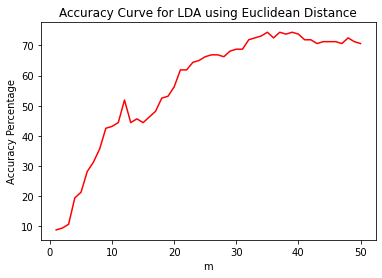

In [26]:
plt.plot(np.arange(1,51), accuracy_curve, color ="red")  
plt.title("Accuracy Curve for LDA using Euclidean Distance")  
plt.xlabel("m")  
plt.ylabel("Accuracy Percentage") 
plt.show()

In [32]:
# true labels
trueLabels_2 = np.arange(0,q)
trueLabels_2 = (trueLabels_2//test_size)

accuracy_curve_2 = []

for m in range(1,51):

    # minimum distance
    min_dist = 999999999

    distances_2 = [0]*q
    classes_2 = [0]*q

    cov_m = np.linalg.inv(surrogate_cov(FF[:,0:m]))
    i = 0
    for sign_test in PFTI_T:
        j = 0
        for sign_train in FF_T:
            dist = mahalanobis_distance(sign_test[0:m],sign_train[0:m],cov_m)
            if(dist < min_dist):
                min_dist = dist
                label = j
            j+=1

        distances_2[i] = min_dist
        classes_2[i] = (label//train_size)
        i+=1
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels_2,classes_2)
    accuracy_curve_2.append(accuracy)
    
   

<ipython-input-4-bc9d3867f7ef>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  cov[z][y] = np.dot(X[:,y].T,X[:,z])/rows


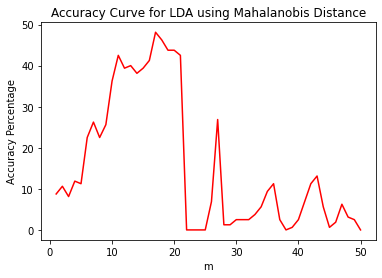

In [33]:
plt.plot(np.arange(1,51), accuracy_curve_2, color ="red")  
plt.title("Accuracy Curve for LDA using Mahalanobis Distance")  
plt.xlabel("m")  
plt.ylabel("Accuracy Percentage") 
plt.show()

### Comments

From the two accuracy curve, we can notice that the for the value of m less than 22, the mahalanobis distance LDA classifier provides almost similar accuracy like the euclidean distance classifier. For higher number of dimensions, the mahalanobis distaance based LDA classifier performs poorly.